In [169]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [170]:
# start = datetime(2001,1,1)
# end  = datetime(2020,1,1)
start = datetime(2020,1,1)
end = datetime.now()
current_date = datetime(2023,1,1)

In [171]:
market = Market()

In [172]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)

In [173]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [174]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [175]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions / 2) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                ledger= ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.14s/it]


In [176]:
trade

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,iteration
0,2001,1,FFIV,1.423265,1.0,0.706608,0,2
1,2001,2,FFIV,2.090631,1.0,0.701299,0,2
2,2001,3,NTAP,2.387940,1.0,1.043478,0,2
3,2001,4,NTAP,2.929974,1.0,1.419660,0,2
4,2001,5,EQIX,3.354809,1.0,1.047244,0,2
...,...,...,...,...,...,...,...,...
2474,2020,8,WYNN,0.116290,1.0,1.185979,10,2
2475,2020,9,APA,0.357243,1.0,0.877141,10,2
2476,2020,10,XOM,0.276729,1.0,1.309288,10,2
2477,2020,11,ABMD,0.156044,1.0,1.144465,10,2


In [177]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
5,True,False,False,False,none,1,tyield1,1,2,wsw_n_n_b_r,4.465576,-3.786266,-1.100412,-0.915142
3,True,False,False,False,flat,1,tyield1,1,0,wsw_n_n_b_r,4.331525,-3.790976,-1.112516,-0.878644
1,True,False,False,False,rrr,1,tyield1,1,1,wsr_n_n_b_r,3.567719,-2.661224,-0.476121,-0.964636
4,True,False,False,False,rrr,1,tyield1,1,1,wsw_n_n_b_r,3.452834,-3.424575,-0.899708,-0.716068
21,True,False,False,False,flat,1,tyield1,1,0,msw_n_n_b_r,3.305910,-4.662121,0.741083,-0.494041
23,True,False,False,False,none,1,tyield1,1,2,msw_n_n_b_r,3.271336,-4.712921,0.738233,-0.481380
2,True,False,False,False,none,1,tyield1,1,2,wsr_n_n_b_r,3.105964,-2.105443,-0.167715,-0.999959
0,True,False,False,False,flat,1,tyield1,1,0,wsr_n_n_b_r,3.028195,-2.149516,-0.192171,-0.943277
18,True,False,False,False,flat,1,tyield1,1,0,msr_n_n_b_r,2.433548,-4.889760,0.728312,-0.292635
20,True,False,False,False,none,1,tyield1,1,2,msr_n_n_b_r,2.433548,-4.889760,0.728312,-0.292635


In [178]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
7,wsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,4.465576,-3.786266,-1.100412,-0.915142
6,wsr_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,3.567719,-2.661224,-0.476121,-0.964636
5,msw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,3.305910,-4.662121,0.741083,-0.494041
4,msr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,2.433548,-4.889760,0.728312,-0.292635
0,dsb_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,1.616722,0.001832,1.000682,336.504719
3,dsw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,1.604158,-0.008066,0.997447,-74.893333
2,dsr_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,1.494181,-0.004821,0.998518,-102.493292
1,dsdr_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,1.458053,-0.007770,0.997559,-58.941658


In [179]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [230]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [231]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [232]:
ledger

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2020,12,APA,4.664541,1.0,1.251121,0,Energy,APA Corporation
1,2020,13,APA,6.592633,1.0,0.749104,0,Energy,APA Corporation
2,2020,14,APA,6.473236,1.0,1.559809,0,Energy,APA Corporation
3,2020,15,NCLH,4.471129,1.0,1.097184,0,Consumer Discretionary,Norwegian Cruise Line Holdings
4,2020,16,NCLH,3.788028,1.0,0.890688,0,Consumer Discretionary,Norwegian Cruise Line Holdings
...,...,...,...,...,...,...,...,...,...
2450,2022,48,VFC,0.161802,1.0,0.905422,19,Consumer Discretionary,VF Corporation
2451,2022,49,MTB,0.089244,1.0,0.911444,19,Financials,M&T Bank
2452,2022,50,AAP,0.131090,1.0,0.966774,19,Consumer Discretionary,Advance Auto Parts
2453,2022,51,META,0.130119,1.0,0.987446,19,Communication Services,Meta Platforms


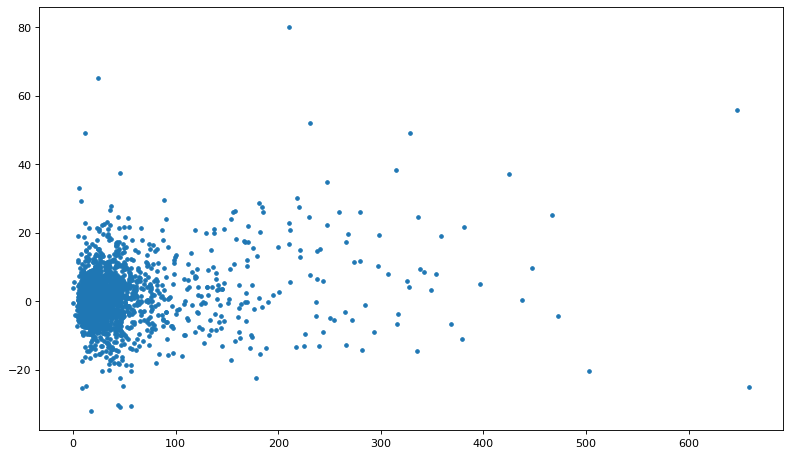

In [233]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [234]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2020,12,APA,4.664541,1.0,1.251121,0,Energy,APA Corporation
124,2020,12,NCLH,4.253382,1.0,1.370887,1,Consumer Discretionary,Norwegian Cruise Line Holdings
248,2020,12,RCL,3.366394,1.0,1.246204,2,Consumer Discretionary,Royal Caribbean Group
372,2020,12,CZR,3.287373,1.0,1.491576,3,Consumer Discretionary,Caesars Entertainment
495,2020,12,HAL,3.074556,1.0,1.079805,4,Energy,Halliburton
618,2020,12,FANG,2.986669,1.0,1.192289,5,Energy,Diamondback Energy
741,2020,12,OXY,2.545958,1.0,0.945326,6,Energy,Occidental Petroleum
864,2020,12,DVN,2.376953,1.0,1.147059,7,Energy,Devon Energy
987,2020,12,MRO,2.366657,1.0,0.997238,8,Energy,Marathon Oil
1110,2020,12,DXC,2.310599,1.0,1.520000,9,Information Technology,DXC Technology


In [235]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
1479,2020,12,PENN,2.107963,1.0,1.802183,12,Consumer Discretionary,Penn National Gaming
135,2020,23,AAL,0.246805,1.0,1.653298,1,Industrials,American Airlines Group
2,2020,14,APA,6.473236,1.0,1.559809,0,Energy,APA Corporation
1110,2020,12,DXC,2.310599,1.0,1.520000,9,Information Technology,DXC Technology
506,2020,23,UAL,0.115003,1.0,1.492477,4,Industrials,United Airlines Holdings
372,2020,12,CZR,3.287373,1.0,1.491576,3,Consumer Discretionary,Caesars Entertainment
129,2020,17,CZR,3.144493,1.0,1.383759,1,Consumer Discretionary,Caesars Entertainment
1119,2020,21,BBWI,0.455756,1.0,1.374900,9,Consumer Discretionary,"Bath & Body Works, Inc."
124,2020,12,NCLH,4.253382,1.0,1.370887,1,Consumer Discretionary,Norwegian Cruise Line Holdings
1602,2020,13,MPC,2.478234,1.0,1.349714,13,Energy,Marathon Petroleum


In [236]:
ledger["actual_returns"].mean()

1.0114574064736166

In [237]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5621181262729125

In [238]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [239]:
portfolio.head(20)

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2020,12,1.251121,1.370887,1.246204,1.491576,1.079805,1.192289,0.945326,1.147059,...,1.076318,1.275393,1.802183,1.026059,1.157771,0.862069,1.288443,1.046429,0.997381,1.262298
1,2020,13,0.749104,0.797091,0.956811,0.933275,1.080224,1.033183,1.086235,0.962719,...,0.989116,0.968801,0.949831,1.349714,1.059685,1.151860,0.956061,0.870580,1.055950,1.168076
2,2020,14,1.559809,1.004562,1.049306,1.042897,0.858011,1.118541,1.260492,1.113251,...,1.259924,0.775911,1.155085,1.220904,1.048537,1.109734,1.241498,1.065900,1.150612,1.019670
3,2020,15,1.097184,1.217791,1.095575,1.058240,1.102235,1.149457,1.128913,1.301471,...,0.864428,1.261106,1.094382,1.005585,0.995408,1.034717,1.036169,0.938893,1.032351,0.915783
4,2020,16,0.890688,0.946443,0.872821,0.909884,1.063738,0.977720,0.902265,0.997647,...,0.941320,0.868033,0.920887,0.901062,0.993414,0.876995,0.992101,0.966879,0.911111,0.945302
5,2020,17,1.190000,1.383759,1.221284,1.245041,1.207958,1.229335,0.998565,1.276139,...,1.023636,1.172439,1.176887,1.182412,1.212155,1.053680,0.963104,1.210191,1.198635,1.198567
6,2020,18,0.854087,0.869380,0.905256,0.866379,1.018349,0.844583,1.009888,0.894446,...,0.980347,0.955065,0.956103,0.988686,1.035714,0.917353,0.923619,1.095322,1.108216,1.061316
7,2020,19,1.261840,0.943615,0.991950,0.910729,1.007639,1.100568,0.998565,1.014721,...,1.000849,0.900743,0.976882,1.128417,0.926821,0.939011,0.967298,0.928739,1.059457,1.063895
8,2020,20,1.120830,1.083633,1.040422,1.042721,1.069750,1.041687,1.034712,1.065877,...,0.985597,1.159879,1.240725,1.012439,1.151897,1.097068,1.000000,1.168228,0.998964,1.115139
9,2020,21,1.296030,1.209559,1.163485,1.111131,1.178729,1.215601,1.242739,1.156077,...,1.247034,1.146274,1.077408,1.221828,1.053242,1.188337,1.211004,1.230474,1.100840,1.195956


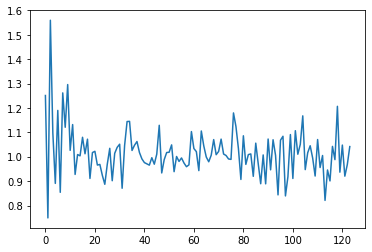

In [240]:
plt.plot(portfolio[0])

In [241]:
positions = 10

In [242]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [243]:
anas.naming

'week'

In [244]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,year,week,pv,daily_returns,adjclose,bench,date_string,date
122,3.448981,5.742799,4.110184,2.775088,3.139919,5.181874,2.058391,4.357261,1.306482,10.440241,2022,43,4.256122,0.977044,10720.654,1.363130,2022-W43,2022-10-28
123,3.106789,5.819410,3.554193,2.969986,3.261135,5.167395,2.101284,4.197451,1.315009,8.908631,2022,44,4.040128,0.972888,11003.568,1.399103,2022-W44,2022-11-04
124,3.238494,6.645514,4.313516,2.848189,3.323579,6.054268,2.463749,4.615424,1.336457,8.815726,2022,45,4.365491,1.082571,10644.398,1.353434,2022-W45,2022-11-11
125,3.200005,5.644135,4.136151,2.489125,3.783782,6.195137,2.345065,4.710811,1.394504,8.304282,2022,46,4.220300,0.978989,10794.274,1.372491,2022-W46,2022-11-18
126,3.861730,5.596402,4.739619,2.335423,4.212715,6.565377,2.429104,4.778052,1.459182,8.952727,2022,47,4.493033,1.063018,11205.862,1.424825,2022-W47,2022-11-25
127,3.617351,5.719765,4.713147,2.305536,4.392061,6.469160,2.319503,4.685226,1.425919,9.225120,2022,48,4.487279,0.991138,11177.650,1.421237,2022-W48,2022-12-02
128,3.790373,5.119543,4.572397,2.425083,4.603079,6.661292,2.366709,4.074327,1.449482,9.846937,2022,49,4.490922,1.001652,11289.046,1.435401,2022-W49,2022-12-09
129,3.488447,4.854701,4.116284,2.076274,4.278919,6.135533,2.208072,3.860916,1.391562,9.596154,2022,50,4.200686,0.929084,11060.000,1.406278,2022-W50,2022-12-16
130,3.376779,5.138199,4.157109,1.698236,4.109651,6.026819,2.259375,3.885306,1.341487,9.864445,2022,51,4.185741,0.981848,11017.476,1.400871,2022-W51,2022-12-23
131,3.517298,5.509449,4.391548,1.909825,4.213580,6.738929,2.248863,4.003042,1.525247,10.597976,2022,52,4.465576,1.067529,10555.298,1.342105,2022-W52,2022-12-30


In [245]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [246]:
cash_analysis["cash"].sum()

253.0271655387328

In [247]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.224150,NaN,NaN,0.000000,0.000000
1,0.944252,1.000000,0.944252,0.000000,0.000000
2,1.137575,0.944252,1.074158,7.415823,7.415823
3,1.133679,1.000000,1.133679,13.367914,20.783737
4,1.133679,1.000000,1.133679,13.367914,34.151651
...,...,...,...,...,...
127,0.991138,1.000000,0.991138,0.000000,248.212049
128,1.001652,0.991138,0.992775,0.000000,248.212049
129,0.929084,1.000000,0.929084,0.000000,248.212049
130,0.981848,0.929084,0.912219,0.000000,248.212049


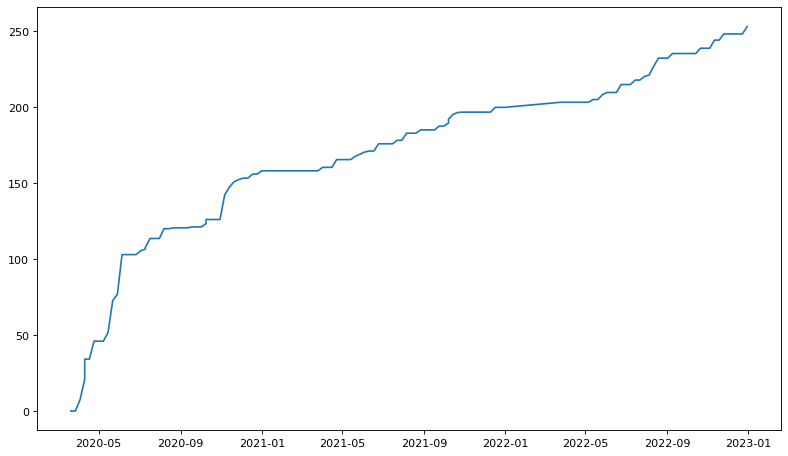

In [248]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

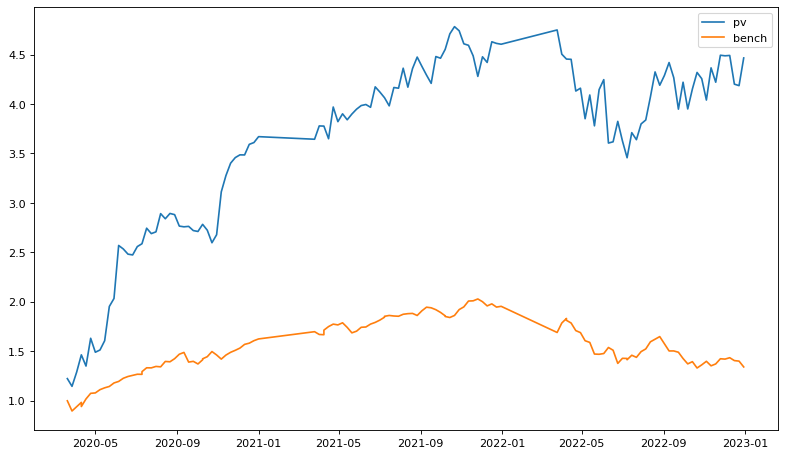

In [249]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [250]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,year,week,pv,daily_returns,adjclose,bench,date_string,date
0,1.251121,1.370887,1.246204,1.491576,1.079805,1.192289,0.945326,1.147059,0.997238,1.520000,2020,12,1.224150,1.224150,7864.731400,1.000000,2020-W12,2020-03-20
1,0.937220,1.092722,1.192381,1.392051,1.166431,1.231852,1.026847,1.104296,0.929948,1.385263,2020,13,1.145901,0.944252,7051.862600,0.896644,2020-W13,2020-03-27
2,1.461883,1.097707,1.251172,1.451766,1.000810,1.377877,1.294332,1.229358,1.111440,1.625915,2020,14,1.290226,1.137575,7392.547600,0.939962,2020-W14,2020-04-03
3,1.603956,1.336778,1.370753,1.536316,1.103128,1.583809,1.461188,1.599973,1.092969,1.955234,2020,15,1.464411,1.133679,7737.125000,0.983775,2020-W15,2020-04-10
4,1.603956,1.336778,1.370753,1.536316,1.103128,1.583809,1.461188,1.599973,1.092969,1.955234,2020,15,1.464411,1.133679,7406.992333,0.941799,2020-W15,2020-04-10
5,1.428624,1.265184,1.196422,1.397869,1.173439,1.548521,1.318380,1.596209,0.965988,1.619301,2020,16,1.350994,0.927321,8011.243000,1.018629,2020-W16,2020-04-17
6,1.700063,1.750710,1.461171,1.740404,1.417465,1.903652,1.316488,2.036985,1.093692,1.897824,2020,17,1.631845,1.205628,8456.769600,1.075278,2020-W17,2020-04-24
7,1.452002,1.522032,1.322733,1.507850,1.443474,1.607792,1.329505,1.821972,1.207469,1.692760,2020,18,1.490759,0.925834,8489.722000,1.079468,2020-W18,2020-05-01
8,1.832194,1.436213,1.312085,1.373243,1.454501,1.769484,1.327597,1.848794,1.169649,1.610994,2020,19,1.513475,1.015000,8749.421000,1.112488,2020-W19,2020-05-08
9,2.053577,1.556328,1.365122,1.431909,1.555952,1.843248,1.373681,1.970588,1.126990,1.793020,2020,20,1.607041,1.057615,8895.040600,1.131004,2020-W20,2020-05-15


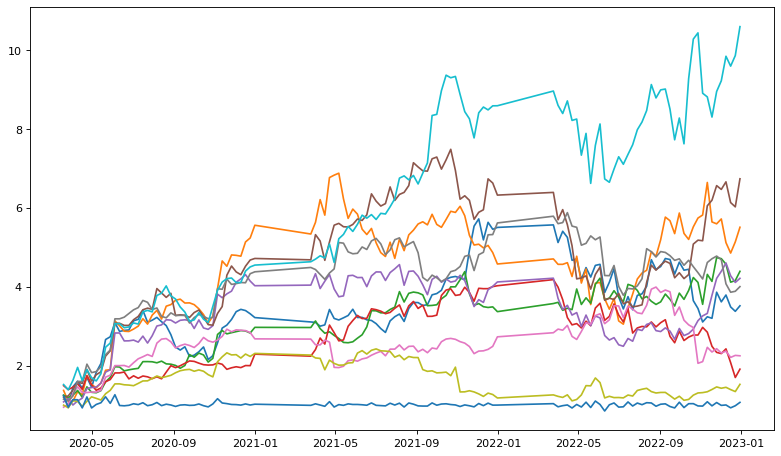

In [251]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [252]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Energy,2020.433234,32.442136,0.617708,1.0,1.026218,8.801187
Real Estate,2020.581395,35.313953,0.324399,1.0,1.024232,12.837209
Industrials,2020.840376,29.338028,0.506951,1.0,1.016083,10.319249
Consumer Discretionary,2021.238710,29.901075,0.575843,1.0,1.013839,8.305376
Financials,2021.042254,29.612676,0.285628,1.0,1.011202,10.957746
Utilities,2020.474359,35.858974,0.178319,1.0,1.008348,9.128205
Information Technology,2021.166220,31.694370,0.262199,1.0,1.007685,9.833780
Materials,2021.366337,32.396040,0.251590,1.0,1.007349,10.544554
Health Care,2021.025641,35.683761,0.246015,1.0,1.005836,9.829060


In [253]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                       
2020 12   PENN   Penn National Gaming                2.107963   
     23   AAL    American Airlines Group             0.246805   
     14   APA    APA Corporation                     6.473236   
     12   DXC    DXC Technology                      2.310599   
     23   UAL    United Airlines Holdings            0.115003   
     12   CZR    Caesars Entertainment               3.287373   
     17   CZR    Caesars Entertainment               3.144493   
     21   BBWI   Bath & Body Works, Inc.             0.455756   
     12   NCLH   Norwegian Cruise Line Holdings      4.253382   
     13   MPC    Marathon Petroleum                  2.478234   
     23   IVZ    Invesco                             0.057083   
     15   UAL    United Airlines Holdings            2.184346   
     21   UAL    United Airlines Holdings            0.884791   
     23   DAL    Delta Air Lines                     0.081085   
     12   EOG    EOG Resources                       1.817636   
     45   OXY    Occidental Petroleum                0.371915   
     17   HAL    Halliburton                         1.845736   
     12   MGM    MGM Resorts                         2.206079   
     45   VLO    Valero Energy                       0.359749   
     12   PXD    Pioneer Natural Resources           1.574581   
     19   CZR    Caesars Entertainment               1.853354   
     15   PENN   Penn National Gaming                1.563010   
     14   DVN    Devon Energy                        2.797088   
          FANG   Diamondback Energy                  2.595302   
     12   APA    APA Corporation                     4.664541   
     21   ALK    Alaska Air Group                    0.436833   
     12   RCL    Royal Caribbean Group               3.366394   
     17   APA    APA Corporation                     2.299528   
     21   AAL    American Airlines Group             0.535360   
     14   PVH    PVH                                 1.539642   

                                                 weekly_delta_sign  \
year week ticker Security                                            
2020 12   PENN   Penn National Gaming                          1.0   
     23   AAL    American Airlines Group                       1.0   
     14   APA    APA Corporation                               1.0   
     12   DXC    DXC Technology                                1.0   
     23   UAL    United Airlines Holdings                      1.0   
     12   CZR    Caesars Entertainment                         1.0   
     17   CZR    Caesars Entertainment                         1.0   
     21   BBWI   Bath & Body Works, Inc.                       1.0   
     12   NCLH   Norwegian Cruise Line Holdings                1.0   
     13   MPC    Marathon Petroleum                            1.0   
     23   IVZ    Invesco                                       1.0   
     15   UAL    United Airlines Holdings                      1.0   
     21   UAL    United Airlines Holdings                      1.0   
     23   DAL    Delta Air Lines                               1.0   
     12   EOG    EOG Resources                                 1.0   
     45   OXY    Occidental Petroleum                          1.0   
     17   HAL    Halliburton                                   1.0   
     12   MGM    MGM Resorts                                   1.0   
     45   VLO    Valero Energy                                 1.0   
     12   PXD    Pioneer Natural Resources                     1.0   
     19   CZR    Caesars Entertainment                         1.0   
     15   PENN   Penn National Gaming                          1.0   
     14   DVN    Devon Energy                                  1.0   
          FANG   Diamondback Energy                            1.0   
     12   APA    APA Corporation                               1.0   
     21   ALK    Alaska Air Group                              1.0   
     12 

In [254]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2020,12,1.157771,1.377093,1.000000,1.099830,0.997381,1.000000,1.000000,1.520000,1.000000,1.000000,1.000000
1,4080400,156,1.099686,1.303277,1.000000,1.117903,1.101014,1.000000,1.062069,1.323282,1.000000,1.000000,1.000000
2,8242408000,2184,1.153061,1.379597,1.000000,1.372837,1.101014,1.000000,0.953515,1.410487,1.000000,1.109734,1.000000
3,16649664160000,32760,1.193093,1.549105,1.000000,1.422879,1.101014,1.000000,1.062876,1.456117,1.000000,1.115931,1.000000
4,33632321603200000,524160,1.193093,1.393651,1.000000,1.366307,1.101014,1.000000,0.976162,1.456117,1.000000,1.115931,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,0,0.856066,3.195705,1.075243,3.435293,2.018612,1.222355,1.170049,2.640038,1.486238,1.788516,1.499967
120,0,0,0.900878,3.219058,1.075243,3.435293,1.876858,1.254479,1.226014,2.690179,1.486238,1.876858,1.544515
121,0,0,0.832411,2.935053,1.075243,3.435293,1.749480,1.213519,1.128355,2.535755,1.486238,1.876858,1.463614
122,0,0,0.822800,2.849527,1.075243,3.471847,1.777940,1.211060,1.194247,2.545410,1.486238,1.876858,1.472860
